### Import Library

In [ ]:
import re
import string 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import nltk

#preprocessing and scoring
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, recall_score, precision_score
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize,RegexpTokenizer
#models and algos

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier


##customer pipeline function
from sklearn.base import BaseEstimator, TransformerMixin

#Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

### Read Dataset

In [ ]:
df = pd.read_csv('fifa_world_cup_2022_tweets.csv')
df['time_hour'] = pd.to_datetime(df['Date Created']).dt.hour
df = df.drop(['Unnamed: 0','Sentiment','Date Created'],axis=1)
df

,Number of Likes,Source of Tweet,Tweet,time_hour
0,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,23
1,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,23
2,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,23
3,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,23
4,0,Twitter for Android,"If the BBC cares so much about human rights, h...",23
...,...,...,...,...
22519,1,Twitter Web App,Here We go World cup 2022 #WorldCup2022,0
22520,0,DenetPro,Anderlecht confirms former Viborg FF's Jesper ...,0
22521,2,Twitter for iPhone,Great thread to read before the start of #Worl...,0
22522,11,Twitter Web App,Raphinha wants Brazil to be united at the #Wor...,0


### Cheking missing & Duplicated Value

In [ ]:
df.isna().sum()

Number of Likes    0
Source of Tweet    0
Tweet              0
time_hour          0
dtype: int64

In [ ]:
df.duplicated().sum()

60

In [ ]:
df = df.drop_duplicates()

### Data Reprocessing

#### Cleaning Tweet

Cleaning Tweet

* Step A : Converting html entities
* Step B : Removing "@user" from all the tweets
* Step C : Changing all the tweets into lowercase
* Step D : Apostrophe Lookup
* Step E : Short Word Lookup
* Step F : Emoticon Lookup
* Step G : Replacing Special Characters with space
* Step H : Replacing Numbers (integers) with space
* Step I : Removing words whom length is 1
* Step J : remove Additional stopwords
* Step K : Stemming
* Step L : Retainment of Relevant Parts of Speech


In [ ]:
#Converting html entities
from bs4 import BeautifulSoup
df['clean_tweet'] = df['Tweet'].apply(lambda x: BeautifulSoup(x).text)

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [ ]:
# remove twitter handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['clean_tweet'], "@[\w]*")

In [ ]:
#Changing all the tweets into lowercase
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: x.lower())

In [ ]:
#Apostrophe Lookup
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [ ]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))

In [ ]:
#Short Word Lookup
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [ ]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))

In [ ]:
#Emoticon Lookup
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [ ]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
df['clean_tweet'] = df['clean_tweet'].astype(str).apply(lambda x: x.encode('latin-1', 'ignore').decode('latin-1'))

In [ ]:
#Replacing Special Characters with space
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))

In [ ]:
#Replacing Numbers (integers) with space
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))

In [ ]:
#Removing words whom length is 1
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [ ]:
#remove Additional stopwords
# RegexpTokenizer
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")
# remove Additional stopwords

alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe","world cup","worldcup","qatar","match","football","fifaworldcup","fifaworldcupqatar","fifa","world","cup","goal","game","amp","goal","win","team","today","country","qatarworldcup","go","qatecu","worldcupqatar"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

In [ ]:
df['clean_tweet'] = df['clean_tweet'].apply(remove_additional_stopwords)

In [ ]:
#Remove StopWord
# Creating token for the clean tweets
df['tweet_token'] = df['clean_tweet'].apply(lambda x: word_tokenize(x))

# Importing stop words from NLTK corpus for english language
stop_words = set(stopwords.words('english'))
df['tweet_token_filtered'] = df['tweet_token'].apply(lambda x: [word for word in x if not word in stop_words])

In [ ]:
#Stemming
# Importing library for stemming
from nltk.stem import PorterStemmer
stemming = PorterStemmer()
df['tweet_stemmed'] = df['tweet_token_filtered'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))

In [ ]:
#Retainment of Relevant Parts of Speech

In [ ]:
#Retainment of Relevant Parts of Speech
def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

In [ ]:
df['Tweet_clean'] = df['tweet_stemmed'].apply(keep_pos)

In [ ]:
df_clean = df[['Source of Tweet','time_hour','Tweet_clean']]
df_clean

,Source of Tweet,time_hour,Tweet_clean
0,Twitter Web App,23,drink http oga tzvg
1,Twitter for iPhone,23,amaz launch video show face canada men nation ...
2,Twitter for iPhone,23,read watch http sqrna dyu
3,Twitter Web App,23,makna shin bright ayzbzgtx jeonjungkook jungko...
4,Twitter for Android,23,bbc care human right homosexu women right say ...
...,...,...,...
22519,Twitter Web App,0,
22520,DenetPro,0,anderlecht viborg jesper fredberg sport direct...
22521,Twitter for iPhone,0,start http jdn
22522,Twitter Web App,0,raphinha want brazil unit http bxncqvafup


### Computing Sentiment Polarity

* Sentimental Classification
* Identifying polarity and subjectivity using TextBlob API.

#### Polaritas
Polaritas mengacu pada penentuan sentimen cenderung pada positif, netral, atau negatif  Polaritas berkisar antara -1 hingga +1, dimana -1 hingga 0 adalah sentimen negatif, rentang 0 hingga +1 sebagai sentimen positif, dan 0 adalah netral. Polaritas kalimat dihitung sebagai jumlah dari polaritas semua
kata dibagi dengan jumlah kata.

#### Subjectivitas 
subjektivitas mengacu pada opini atau emosi individu. Subjektivitas berkisar antara 0.0 hingga 1.0 dimana 0.0 sangat objektif dan 1.0 sangat subjektif

In [ ]:
#NLP using Textblon
from textblob import TextBlob
#Create a function to get the subjectivity
def getSubjectivity(twt):
  return TextBlob(twt).sentiment.subjectivity

#Create a function to get the polarity
def getPolarity(twt):
  return TextBlob(twt).sentiment.polarity

In [ ]:
#Create two new columns to save the results of the created functions 
df_clean['Subjectivity'] = df_clean['Tweet_clean'].apply(getSubjectivity)
df_clean['Polarity'] = df_clean['Tweet_clean'].apply(getPolarity)

In [ ]:
# Creating a function to classify or label the sentiments as negative, positive and neutral
def getSentiment(value):
  if value < 0:
    return 'Negative'
  elif value > 0:
    return 'Positive'
  else:
    return 'Neutral'

In [ ]:
# Create a new column 'Sentiment'
df_clean['Sentiment'] = df_clean['Polarity'].apply(getSentiment)

In [ ]:
#because neutral too many, only using positive and negative sentiment
filter = df_clean['Sentiment'].str.contains('Neutral')
df_clean = df_clean[~filter]

### EDA

In [ ]:
num = ['time_hour','Subjectivity','Polarity']
cat = ['Source of Tweet','Sentiment']
df_clean[num].describe()

,time_hour,Subjectivity,Polarity
count,5133.000000,5133.000000,5133.000000
mean,14.504773,0.530781,0.107113
std,4.018642,0.269571,0.407060
min,0.000000,0.000000,-1.000000
25%,14.000000,0.333333,-0.200000
50%,16.000000,0.500000,0.200000
75%,16.000000,0.667857,0.375000
max,23.000000,1.000000,1.000000


* Observation : 
1. Berdasarkan Subjectivitas, rata-rata mendapat nilai 0.53, yang berarti sentiment konsumen cenderung bersifat subjektif
2. Berdasarkan Polaritas, rata-rata mendapat nilai 0.1, yang berarti sentiment konsumen sedikit cenderung positif
3. berdasarkan waktu, trafic konsumen melakukan tweet pada jam 14.49 GMT pada saat acara penutupan acara opening FIFA world Cup 

In [ ]:
df_clean[cat].describe()

,Source of Tweet,Sentiment
count,5133,5133
unique,59,2
top,Twitter for iPhone,Positive
freq,2152,3284


In [ ]:
def percent_data(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

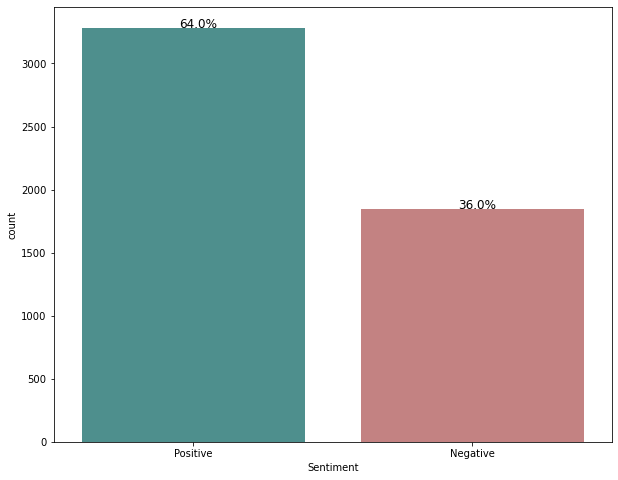

In [ ]:
plt.figure(figsize = (10,8))
ax = sns.countplot(data=df_clean, x='Sentiment',palette=["#439A97", "#CE7777"])
percent_data(ax,df_clean.Sentiment)

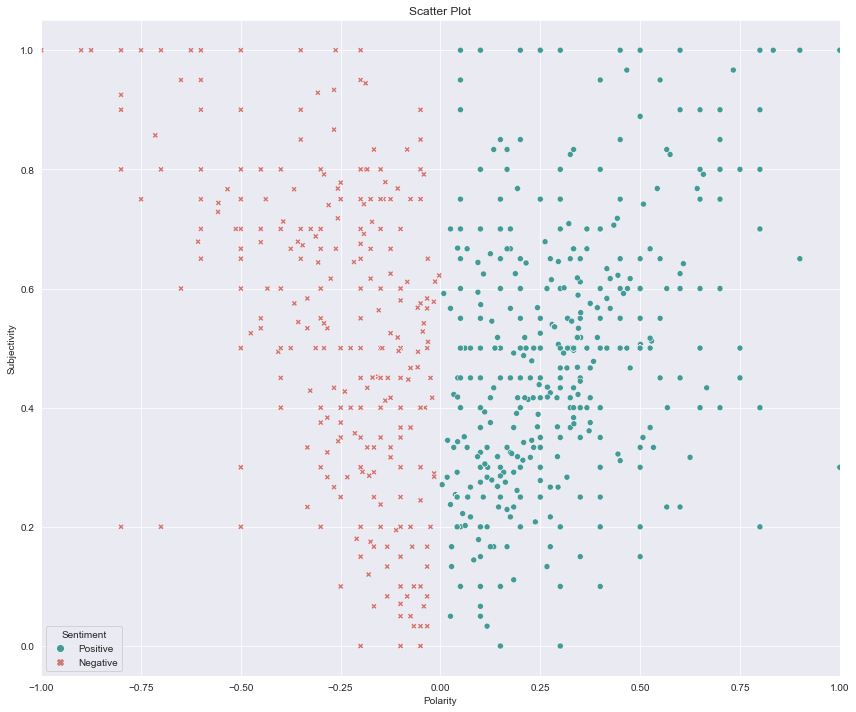

In [ ]:
# Create scatter plot
sns.set_style('darkgrid')
plt.figure(figsize = (12,10))

markers = {'Positive':'o','Negative':'X'}

sns.scatterplot(data=df_clean, x='Polarity', y='Subjectivity', hue = 'Sentiment', style = 'Sentiment', markers = markers, palette=["#439A97", "#CE7777"]).set(xlim=(-1,1))
plt.title('Scatter Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.tight_layout()

<AxesSubplot:xlabel='time_hour', ylabel='Count'>

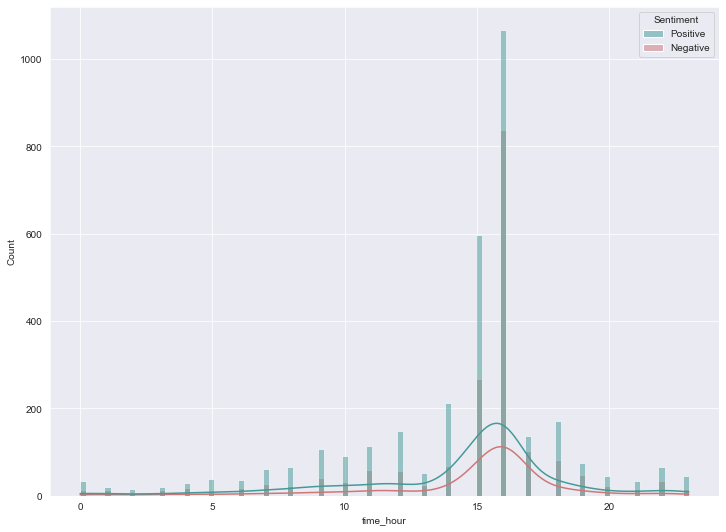

In [ ]:
plt.figure(figsize = (12,9))
sns.histplot(data=df_clean, x="time_hour", kde=True,hue = 'Sentiment',palette=["#439A97", "#CE7777"])

### World Cloud

In [ ]:
#Split postive and negative sentiment
df_clean_pos = df_clean[df_clean['Sentiment']=='Positive']
df_clean_neg = df_clean[df_clean['Sentiment']=='Negative']

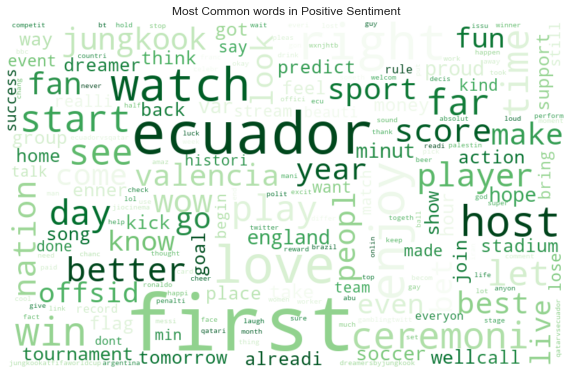

<Figure size 432x288 with 0 Axes>

In [ ]:
#visualizing all the words in our data which positive sentiment using the wordcloud plot.
all_words = ' '.join([text for text in df_clean_pos['Tweet_clean']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21,colormap='Greens',background_color="white",collocations=False, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in Positive Sentiment")
plt.show()
plt.savefig("cloud_1.jpg", format="jpg")
plt.show()

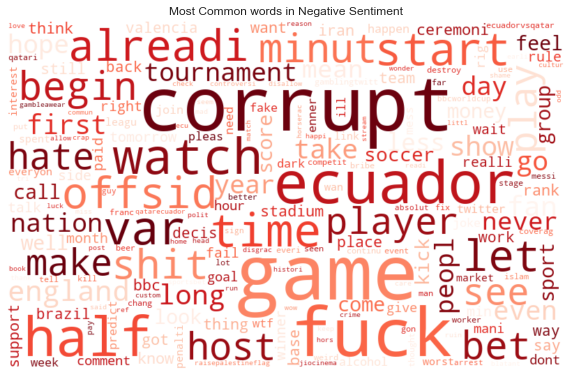

<Figure size 432x288 with 0 Axes>

In [ ]:
#visualizing all the words in our data which negative sentiment using the wordcloud plot.
all_words = ' '.join([text for text in df_clean_neg['Tweet_clean']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21,colormap='Reds',collocations=False,background_color="white", max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in Negative Sentiment")
plt.show()
plt.savefig("cloud_2.jpg", format="jpg")
plt.show()

In [ ]:
df_clean = df_clean[['Tweet_clean','Sentiment']]
df_clean['Sentiment'] = df_clean['Sentiment'].map({'Positive': 1, 'Negative': 0})
df_clean

,Tweet_clean,Sentiment
1,amaz launch video show face canada men nation ...,1
3,makna shin bright ayzbzgtx jeonjungkook jungko...,1
4,bbc care human right homosexu women right say ...,1
9,togeth well hungri love,1
10,tri help soccer minut inaugur deni perfectli e...,0
...,...,...
22509,germani player cant see honest,1
22512,cannt put asid month enjoy sometim realli feel...,1
22514,start tonight flood activ media platform readi...,1
22515,resid justin year person trainer town kisii li...,1


## Machine Learning for Validation

Extracting Features from Cleaned Tweets

Bag-of-words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90,min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df_clean['Tweet_clean'])

TF-IDF

In [ ]:
tfidf_vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
tfidf = tfidf_vectoriser.fit_transform(df_clean['Tweet_clean'])

#### Classification & Evaluation

Split data

In [ ]:
train_bow = bow[:5133,:]
test_bow = bow[5133:,:]

#split data into train & valid set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow,df_clean['Sentiment'],
                                                        random_state=42,
                                                        test_size=0.2)

In [ ]:
train_tfidf = tfidf[:5133,:]
test_tfidf = tfidf[5133:,:]

#split data into train & valid set
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(train_tfidf,df_clean['Sentiment'],
                                                        random_state=42,
                                                        test_size=0.2)

In [ ]:
def evaluate_model(model, x_test = xvalid_bow, y_test = yvalid):
    y_pred = model.predict(x_test)    
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('------')
    print('Confusion Matrix:')
    print()
    print(classification_report(y_test, y_pred))
    print('------')
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('Assuming 1 as positive, we get:')
    print('')
    print('True Positive:', tp)
    print('True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    print('')
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', 2 * (precision * recall)/(precision + recall))
    print('-----')
    print('ROC AUC')
    
    plot_roc_curve(model, x_test, y_test)
    print('Area under Curve of the ROC:', roc_auc_score(y_test,
                                                       model.predict_proba(x_test)[:,1]))

### Logistic Regression

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

Accuracy: 0.9250243427458618
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.94      0.84      0.88       350
           1       0.92      0.97      0.94       677

    accuracy                           0.93      1027
   macro avg       0.93      0.90      0.91      1027
weighted avg       0.93      0.93      0.92      1027

------
Assuming 1 as positive, we get:

True Positive: 657
True Negative: 293
False Positive: 57
False Negative: 20

Precision: 0.9201680672268907
Recall: 0.9704579025110783
F1-Score: 0.944644140905823
-----
ROC AUC
Area under Curve of the ROC: 0.9744946191179574


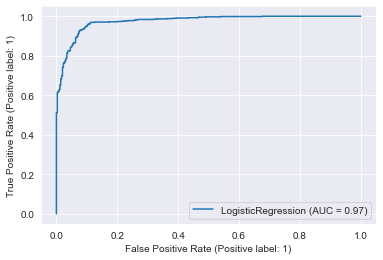

In [ ]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain)
evaluate_model(lreg,xvalid_bow,yvalid)

Accuracy: 0.8568646543330087
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.98      0.59      0.74       350
           1       0.83      0.99      0.90       677

    accuracy                           0.86      1027
   macro avg       0.90      0.79      0.82      1027
weighted avg       0.88      0.86      0.85      1027

------
Assuming 1 as positive, we get:

True Positive: 672
True Negative: 208
False Positive: 142
False Negative: 5

Precision: 0.8255528255528255
Recall: 0.9926144756277696
F1-Score: 0.9014084507042254
-----
ROC AUC
Area under Curve of the ROC: 0.9834901878033341


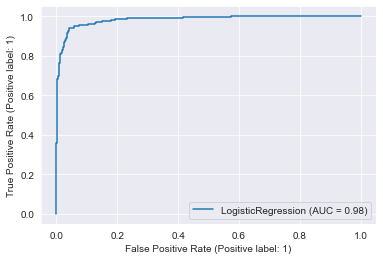

In [ ]:
lreg = LogisticRegression()
lreg.fit(xtrain_tfidf, ytrain)
evaluate_model(lreg,xvalid_tfidf,yvalid)

### Naive Bayes

Accuracy: 0.8928919182083739
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       350
           1       0.92      0.92      0.92       677

    accuracy                           0.89      1027
   macro avg       0.88      0.88      0.88      1027
weighted avg       0.89      0.89      0.89      1027

------
Assuming 1 as positive, we get:

True Positive: 622
True Negative: 295
False Positive: 55
False Negative: 55

Precision: 0.9187592319054653
Recall: 0.9187592319054653
F1-Score: 0.9187592319054653
-----
ROC AUC
Area under Curve of the ROC: 0.9490799746782022


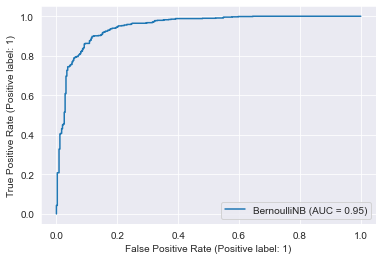

In [ ]:
naivebern_i = BernoulliNB()
naivebern_i.fit(xtrain_bow, ytrain)
evaluate_model(naivebern_i,xvalid_bow,yvalid)

Accuracy: 0.747809152872444
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.88      0.30      0.45       350
           1       0.73      0.98      0.84       677

    accuracy                           0.75      1027
   macro avg       0.80      0.64      0.64      1027
weighted avg       0.78      0.75      0.70      1027

------
Assuming 1 as positive, we get:

True Positive: 662
True Negative: 106
False Positive: 244
False Negative: 15

Precision: 0.7306843267108167
Recall: 0.9778434268833087
F1-Score: 0.8363866077068857
-----
ROC AUC
Area under Curve of the ROC: 0.9098417387634522


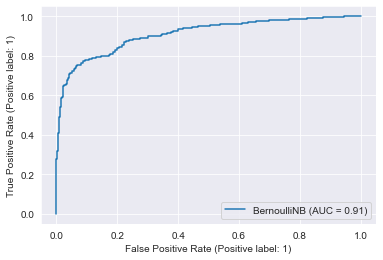

In [ ]:
naivebern_i = BernoulliNB()
naivebern_i.fit(xtrain_tfidf, ytrain)
evaluate_model(naivebern_i,xvalid_tfidf,yvalid)

### SVM

Accuracy: 0.9328140214216164
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       350
           1       0.94      0.96      0.95       677

    accuracy                           0.93      1027
   macro avg       0.93      0.92      0.92      1027
weighted avg       0.93      0.93      0.93      1027

------
Assuming 1 as positive, we get:

True Positive: 651
True Negative: 307
False Positive: 43
False Negative: 26

Precision: 0.9380403458213257
Recall: 0.9615952732644018
F1-Score: 0.949671772428884
-----
ROC AUC
Area under Curve of the ROC: 0.9721734543152564


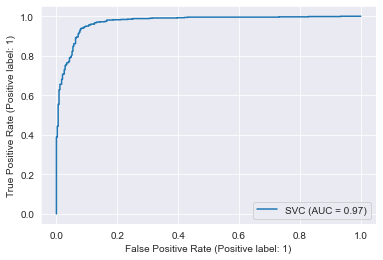

In [ ]:
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1,probability= True)
svc.fit(xtrain_bow, ytrain)
evaluate_model(svc,xvalid_bow,yvalid)

Accuracy: 0.9464459591041869
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       350
           1       0.93      0.99      0.96       677

    accuracy                           0.95      1027
   macro avg       0.95      0.93      0.94      1027
weighted avg       0.95      0.95      0.95      1027

------
Assuming 1 as positive, we get:

True Positive: 669
True Negative: 303
False Positive: 47
False Negative: 8

Precision: 0.9343575418994413
Recall: 0.9881831610044313
F1-Score: 0.9605168700646087
-----
ROC AUC
Area under Curve of the ROC: 0.992652458324541


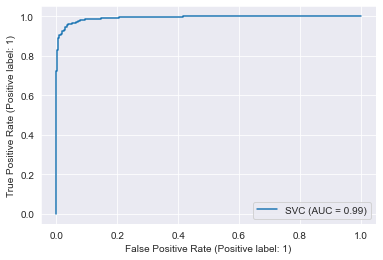

In [ ]:
svc = svm.SVC(kernel='linear', C=1,probability= True)
svc.fit(xtrain_tfidf, ytrain)
evaluate_model(svc,xvalid_tfidf,yvalid)

### Random Forest

Accuracy: 0.9318403115871471
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       350
           1       0.94      0.96      0.95       677

    accuracy                           0.93      1027
   macro avg       0.93      0.92      0.92      1027
weighted avg       0.93      0.93      0.93      1027

------
Assuming 1 as positive, we get:

True Positive: 647
True Negative: 310
False Positive: 40
False Negative: 30

Precision: 0.9417758369723436
Recall: 0.9556868537666174
F1-Score: 0.9486803519061583
-----
ROC AUC
Area under Curve of the ROC: 0.957440388267567


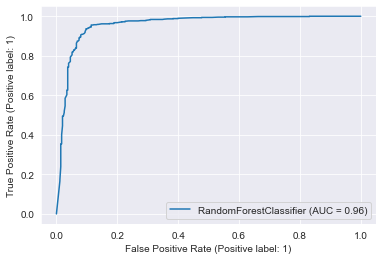

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(xtrain_bow, ytrain)
evaluate_model(rf,xvalid_bow,yvalid)

Accuracy: 0.9211295034079844
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       350
           1       0.90      0.98      0.94       677

    accuracy                           0.92      1027
   macro avg       0.93      0.89      0.91      1027
weighted avg       0.92      0.92      0.92      1027

------
Assuming 1 as positive, we get:

True Positive: 666
True Negative: 280
False Positive: 70
False Negative: 11

Precision: 0.904891304347826
Recall: 0.983751846381093
F1-Score: 0.9426751592356687
-----
ROC AUC
Area under Curve of the ROC: 0.979854399662376


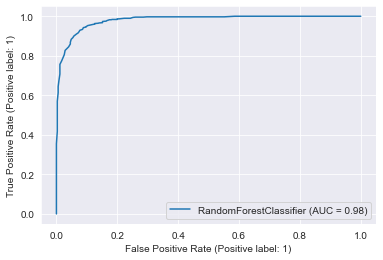

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(xtrain_tfidf, ytrain)
evaluate_model(rf,xvalid_tfidf,yvalid)

### XGB

In [ ]:
import xgboost as xgb

[23:54:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9328140214216164
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       350
           1       0.93      0.97      0.95       677

    accuracy                           0.93      1027
   macro avg       0.93      0.92      0.92      1027
weighted avg       0.93      0.93      0.93      1027

------
Assuming 1 as positive, we get:

True Positive: 657
True Negative: 301
False Positive: 49
False Negative: 20

Precision: 0.9305949008498584
Recall: 0.9704579025110783
F1-Score: 0.9501084598698482
-----
ROC AUC
Area under Curve of the ROC: 0.9741696560455793


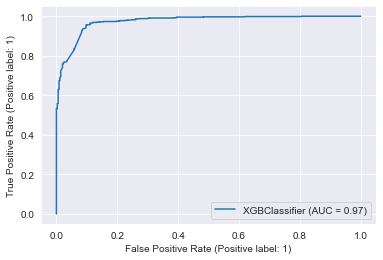

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(xtrain_bow, ytrain)
evaluate_model(xgb_model,xvalid_bow,yvalid)

[23:54:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9406037000973709
------
Confusion Matrix:

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       350
           1       0.93      0.99      0.96       677

    accuracy                           0.94      1027
   macro avg       0.95      0.92      0.93      1027
weighted avg       0.94      0.94      0.94      1027

------
Assuming 1 as positive, we get:

True Positive: 667
True Negative: 299
False Positive: 51
False Negative: 10

Precision: 0.9289693593314763
Recall: 0.9852289512555391
F1-Score: 0.9562724014336917
-----
ROC AUC
Area under Curve of the ROC: 0.9918738130407259


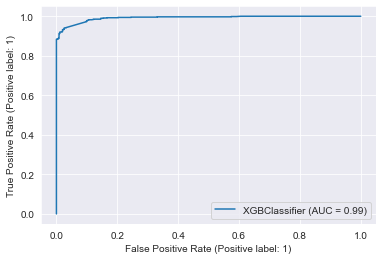

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(xtrain_tfidf, ytrain)
evaluate_model(xgb_model,xvalid_tfidf,yvalid)

## Best Model = SVM - TF-IDF

In [ ]:
model_score = pd.DataFrame(columns=["model_f1_train","params_used", "f1","precision","recall"])


def model_prediction(model, params):
    
    model = GridSearchCV(model, param_grid= params, cv= kfold)
    
    model.fit(xtrain_tfidf, ytrain)
    y_pred = model.predict(xvalid_tfidf)
    
    print ("Model and params: ", model.best_estimator_, model.best_params_) 
    print("\n")
    print("Train score: ", model.best_score_)
    print("test score: ",accuracy_score(yvalid,y_pred))
    print("\n")
    print("Test Report:")
    print(classification_report(yvalid,y_pred))
    return y_pred, model

In [ ]:
kfold =StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [ ]:
def model_scoring(y_pred, model):
    global y_test
    global model_score
    
    df = pd.DataFrame(data = [[model.best_score_,
                           model.best_params_,
                           f1_score(yvalid,y_pred,average="macro"),
                           precision_score(yvalid,y_pred,average="macro"),
                           recall_score(yvalid,y_pred,average="macro")
                          ]] , 
                  columns =model_score.columns, 
                  index=[str(model.best_estimator_)])
    model_score = model_score.append ( df ) 

In [ ]:
svc = svm.SVC(kernel='linear', C=1,probability= True)
svc.fit(xtrain_tfidf, ytrain)
evaluate_model(svc,xvalid_tfidf,yvalid)

In [ ]:
svc = svm.SVC()

svc_params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}  
svc_gridcv = GridSearchCV(svc, svc_params, refit = True, verbose = 3)
svc_gridcv.fit(xtrain_tfidf, ytrain)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.651 total time=   1.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.647 total time=   1.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.649 total time=   1.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.649 total time=   1.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.660 total time=   1.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.635 total time=   1.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.636 total time=   1.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.635 total time=   1.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.635 total time=   1.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.635 total time=   1.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.635 total time=   1.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.894 total time=   1.3s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.907 total time=   1.3s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.887 total time=   1.3s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.894 total time=   1.3s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.938 total time=   1.3s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.944 total time=   1.2s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.952 total time=   1.2s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.933 total time=   1.2s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.948 total time=   1.2s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.942 total time=   1.4s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.944 total time=   1.4s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.954 total time=   1.3s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
cv_result = pd.DataFrame(svc_gridcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score').head(1)

,params,mean_test_score,rank_test_score
23,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",0.946177,1


In [ ]:
svm_params = {"C": [1000],
               'gamma': [0.001],
               'kernel':['rbf']}

In [ ]:
svm_pred, svm_m = model_prediction(svc, svm_params)

Model and params:  SVC(C=1000, gamma=0.001) {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


Train score:  0.9447149194946522
test score:  0.9591041869522883


Test Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       350
           1       0.95      0.99      0.97       677

    accuracy                           0.96      1027
   macro avg       0.96      0.95      0.95      1027
weighted avg       0.96      0.96      0.96      1027



In [ ]:
model_scoring(svm_pred, svm_m)

In [ ]:
model_score

,model_f1_train,params_used,f1,precision,recall
"SVC(C=1000, gamma=0.001)",0.944715,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",0.953625,0.963472,0.94552


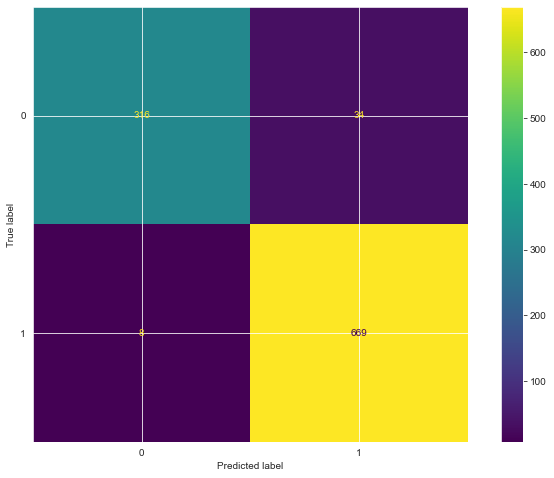

In [ ]:
# the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12,8))
y_pred = svc_gridcv.best_estimator_.predict(xvalid_tfidf)

cm = confusion_matrix(yvalid, y_pred, labels=svc_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=svc_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()